<a href="https://colab.research.google.com/github/MonilSompura/Digital-Clock/blob/master/TransformerTableOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 25.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

In [ ]:
from transformers import AutoModelForObjectDetection
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [ ]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)

cuda


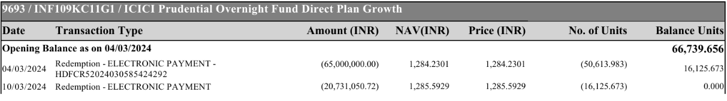

In [ ]:
from PIL import Image
from huggingface_hub import hf_hub_download
# Loading an example image
file_path = "page0Table.png"
image = Image.open(file_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

In [ ]:
from torchvision import transforms
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size
    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))
        return resized_image
detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 111, 800])


In [ ]:
import torch
with torch.no_grad():
  outputs = model(pixel_values)

In [ ]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.51 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"
def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]
    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score), 'bbox': [float(elem) for elem in bbox]})
    return objects


In [ ]:
objects = outputs_to_objects(outputs, image.size, id2label)

print(objects)

[{'label': 'table', 'score': 0.999893069267273, 'bbox': [-3.676621675491333, 39.594425201416016, 1211.42138671875, 154.5560760498047]}]


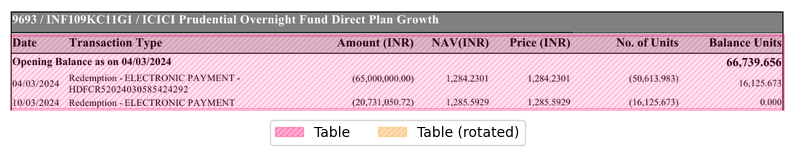

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img
def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()
    for det_table in det_tables:
        bbox = det_table['bbox']
        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth, edgecolor='none', facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth, edgecolor=edgecolor, facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0, edgecolor=edgecolor, facecolor='none', linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)
    plt.xticks([], [])
    plt.yticks([], [])
    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45), label='Table', hatch='//////', alpha=0.3),                      Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),                               label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0, fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')
    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)
    return fig

fig = visualize_detected_tables(image, objects)

visualized_image = fig2img(fig)

In [ ]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue
        cropped_table = {}
        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]
        cropped_img = img.crop(bbox)
        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox
        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens
        table_crops.append(cropped_table)
    return table_crops

In [ ]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10
tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table
cropped_table.save("table.jpg")

In [ ]:
from transformers import TableTransformerForObjectDetection
# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)

config.json:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): TableTransformerFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBasicLayer(
                    (shortcut): Identity()
                    (layer): Sequential(
                      (0): ResNetConvLayer(
                        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [ ]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

torch.Size([1, 3, 95, 1000])


In [ ]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"
cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9999558925628662, 'bbox': [84.16346740722656, -8.225440979003906e-05, 442.24267578125, 114.21320343017578]}, {'label': 'table column', 'score': 0.9999529123306274, 'bbox': [917.8748168945312, -0.057033151388168335, 1077.85888671875, 114.2033920288086]}, {'label': 'table column', 'score': 0.999437153339386, 'bbox': [652.5482788085938, 0.038248300552368164, 772.7560424804688, 114.17607116699219]}, {'label': 'table column', 'score': 0.9999240636825562, 'bbox': [769.9745483398438, 0.02938196063041687, 918.968994140625, 114.17381286621094]}, {'label': 'table row', 'score': 0.9902403354644775, 'bbox': [-4.749063014984131, 24.897903442382812, 1214.893310546875, 54.63591003417969]}, {'label': 'table column', 'score': 0.9998891353607178, 'bbox': [1076.300048828125, 0.011885762214660645, 1215.0242919921875, 114.40158081054688]}, {'label': 'table column header', 'score': 0.9875378012657166, 'bbox': [-5.065826416015625, -0.053343698382377625, 1214.85791015625,

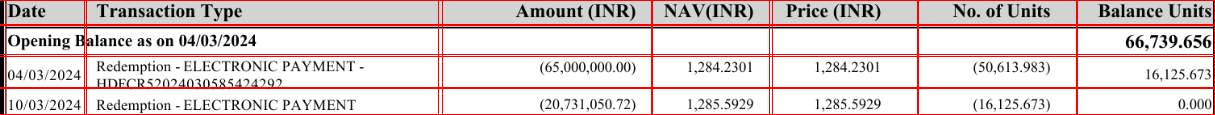

In [ ]:
from PIL import ImageDraw
cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)
for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")
cropped_table_visualized

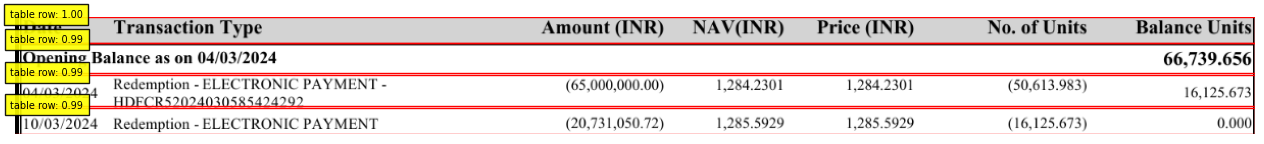

In [ ]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")
    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()
    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]
        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=1))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=7, bbox=dict(facecolor='yellow', alpha=0.9))
          plt.axis('off')

plot_results(cells, class_to_visualize="table row")

In [ ]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']
    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])
    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox
    # Generate cell coordinates and count cells in each row
    cell_coordinates = []
    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})
        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])
        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})
    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])
    return cell_coordinates
cell_coordinates = get_cell_coordinates_by_row(cells)

In [ ]:
len(cell_coordinates)

4

In [ ]:
len(cell_coordinates[0]["cells"])

7

In [ ]:
cell_coordinates

[{'row': [-4.9697980880737305,
   -0.06551563739776611,
   1214.944580078125,
   25.142793655395508],
  'cells': [{'column': [5.939542293548584,
     0.02398744225502014,
     86.03350067138672,
     114.50080108642578],
    'cell': [5.939542293548584,
     -0.06551563739776611,
     86.03350067138672,
     25.142793655395508]},
   {'column': [84.16346740722656,
     -8.225440979003906e-05,
     442.24267578125,
     114.21320343017578],
    'cell': [84.16346740722656,
     -0.06551563739776611,
     442.24267578125,
     25.142793655395508]},
   {'column': [438.38006591796875,
     -0.008108913898468018,
     651.4530029296875,
     114.28485870361328],
    'cell': [438.38006591796875,
     -0.06551563739776611,
     651.4530029296875,
     25.142793655395508]},
   {'column': [652.5482788085938,
     0.038248300552368164,
     772.7560424804688,
     114.17607116699219],
    'cell': [652.5482788085938,
     -0.06551563739776611,
     772.7560424804688,
     25.142793655395508]},
   {'

In [ ]:
for row in cell_coordinates:
  print(row["cells"])

[{'column': [5.939542293548584, 0.02398744225502014, 86.03350067138672, 114.50080108642578], 'cell': [5.939542293548584, -0.06551563739776611, 86.03350067138672, 25.142793655395508]}, {'column': [84.16346740722656, -8.225440979003906e-05, 442.24267578125, 114.21320343017578], 'cell': [84.16346740722656, -0.06551563739776611, 442.24267578125, 25.142793655395508]}, {'column': [438.38006591796875, -0.008108913898468018, 651.4530029296875, 114.28485870361328], 'cell': [438.38006591796875, -0.06551563739776611, 651.4530029296875, 25.142793655395508]}, {'column': [652.5482788085938, 0.038248300552368164, 772.7560424804688, 114.17607116699219], 'cell': [652.5482788085938, -0.06551563739776611, 772.7560424804688, 25.142793655395508]}, {'column': [769.9745483398438, 0.02938196063041687, 918.968994140625, 114.17381286621094], 'cell': [769.9745483398438, -0.06551563739776611, 918.968994140625, 25.142793655395508]}, {'column': [917.8748168945312, -0.057033151388168335, 1077.85888671875, 114.203392

In [ ]:
for row in cell_coordinates:
  print(row["cells"][0]["column"])

[5.939542293548584, 0.02398744225502014, 86.03350067138672, 114.50080108642578]
[5.939542293548584, 0.02398744225502014, 86.03350067138672, 114.50080108642578]
[5.939542293548584, 0.02398744225502014, 86.03350067138672, 114.50080108642578]
[5.939542293548584, 0.02398744225502014, 86.03350067138672, 114.50080108642578]


In [ ]:
print("BEFORE INCREMENT\n")
for row in cell_coordinates:
  values = row["cells"][0]["column"]
  row["cells"][0]["column"] = values + 0.1


BEFORE INCREMENT



TypeError: can only concatenate list (not "float") to list

In [ ]:
import numpy as np
import csv
import easyocr
from tqdm.auto import tqdm
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        # crop cell out of image
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)


      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)
      data[idx] = row_text
    print("Max number of columns:", max_num_columns)


    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data
    return data
data = apply_ocr(cell_coordinates)
for row, row_data in data.items():
    print(row_data)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Max number of columns: 7
['Date', 'Transaction Type', 'Amount (INR)', 'NAV(INR)', 'Price (INR)', 'No. of Units', 'Balance Units ']
['Opening', 'alance as on 04/03/2024', '66,739.6561', '', '', '', '']
['04/03/2024', 'Redemption ELECTRONIC PAYMENT HDFCR{202403058s42420)', '(65,0uO.Uuu.uu)', '1,284.2301', '1,284.2301', '(50,613.983)', '125.673]']
['10/03/2024', 'Redemption ELECTRONIC PAYMENT', '(20,731,050.72)', '1,285.5929', '285.5929', '(16,125.673)', 'Quui']
